In [1]:
import pandas as pd
from sklearn.utils import resample

# Load your dataset
df=  pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX08RAEN/sentiment-text-threeclass/train.txt",header=None, sep="\\|\\|\\|",names=['y','X'])
df.head()

C:\Users\Amar\AppData\Local\Temp\ipykernel_3844\3099955251.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df=  pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX08RAEN/sentiment-text-threeclass/train.txt",header=None, sep="\\|\\|\\|",names=['y','X'])


,y,X
0,1,The Rock is destined to be the 21st Century '...
1,1,The gorgeously elaborate continuation of `` T...
2,1,Singer\/composer Bryan Adams contributes a sl...
3,0,You 'd think by now America would have had en...
4,1,Yet the act is still charming here .


In [2]:
print("Columns in your dataset:")
print(df.columns)


Columns in your dataset:
Index(['y', 'X'], dtype='object')


In [3]:
print("Original class distribution:\n", df['y'].value_counts())


Original class distribution:
 y
 1    3610
-1    3310
 0    1624
Name: count, dtype: int64


In [4]:
from sklearn.utils import resample

# Separate each class
neutral_df = df[df['y'] == 0]
positive_df = df[df['y'] == 1]
negative_df = df[df['y'] == -1]

# Oversample the neutral class to match the majority class
neutral_upsampled = resample(neutral_df, 
                             replace=True,       # Sample with replacement
                             n_samples=3500,     # Match close to other classes
                             random_state=42)

# Combine back with original positive and negative
df_balanced = pd.concat([positive_df, negative_df, neutral_upsampled])

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Confirm new distribution
print("New class distribution:\n", df_balanced['y'].value_counts())


New class distribution:
 y
 1    3610
 0    3500
-1    3310
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split

# Features and labels
X = df_balanced['X'].values
y = df_balanced['y'].values

# Stratified split to preserve class ratio
train_texts, test_texts, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training samples:", len(train_texts))
print("Testing samples:", len(test_texts))


Training samples: 8336
Testing samples: 2084


In [6]:
!pip install transformers



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
!pip install torch torchvision torchaudio



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())


2.7.1+cpu
CUDA available: False


In [9]:
from transformers import DistilBertForSequenceClassification

# Load pre-trained DistilBERT with classification head (3 output classes: -1, 0, 1)
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3  # Because we have 3 sentiment classes
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

C:\Users\Amar\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Amar\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of DistilBertForSequenceClassification were not initialized from the model check

In [11]:
def tokenize_data(texts, labels):
    # Tokenize the input texts
    encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='pt')
    
    # Convert labels to PyTorch tensor
    label_map = {-1: 0, 0: 1, 1: 2}  # Shift labels to 0, 1, 2
    mapped_labels = [label_map[label] for label in labels]
    labels_tensor = torch.tensor(mapped_labels)

    return encodings, labels_tensor


In [13]:
from transformers import DistilBertTokenizer

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


In [14]:
def tokenize_data(texts, labels):
    # Tokenize the input texts
    encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='pt')
    
    # Convert labels to PyTorch tensor
    label_map = {-1: 0, 0: 1, 1: 2}  # Shift labels to 0, 1, 2
    mapped_labels = [label_map[label] for label in labels]
    labels_tensor = torch.tensor(mapped_labels)

    return encodings, labels_tensor


In [16]:
# Convert Series to list of strings
train_texts = train_texts.tolist()
test_texts = test_texts.tolist()


In [17]:
train_encodings, train_labels_tensor = tokenize_data(train_texts, train_labels)
test_encodings, test_labels_tensor = tokenize_data(test_texts, test_labels)



In [18]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [19]:

# Wrap datasets
train_dataset = SentimentDataset(train_encodings, train_labels_tensor)
test_dataset = SentimentDataset(test_encodings, test_labels_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)



In [ ]:
from transformers import DistilBertForSequenceClassification

# Load pre-trained DistilBERT with classification head (3 output classes: -1, 0, 1)
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3  # Because we have 3 sentiment classes
)


In [20]:
from transformers import BertForSequenceClassification

# Load BERT with classification head
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

C:\Users\Amar\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Amar\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to re

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [23]:
from torch.optim import AdamW
from transformers import get_scheduler


In [25]:
from torch.utils.data import DataLoader

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)


In [26]:
# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define scheduler
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)


In [27]:
from tqdm import tqdm
import torch.nn.functional as F

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss = 0

    loop = tqdm(train_dataloader, leave=False)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss:.4f}")



Epoch 1/3


C:\Users\Amar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
                                                                                                                       

Average Training Loss: 0.7776

Epoch 2/3


Average Training Loss: 0.3597

Epoch 3/3


Average Training Loss: 0.0993


In [28]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Put model in evaluation mode
model.eval()

# Store predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.79      0.82       662
     Neutral       0.79      0.87      0.83       700
    Positive       0.88      0.85      0.87       722

    accuracy                           0.84      2084
   macro avg       0.84      0.84      0.84      2084
weighted avg       0.84      0.84      0.84      2084



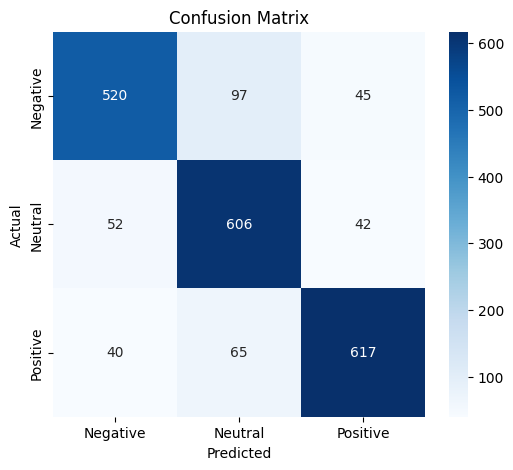

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Neutral", "Positive"]))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [39]:
model.config.id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}
model.config.label2id = {"Negative": 0, "Neutral": 1, "Positive": 2}


In [40]:
model.save_pretrained("sentiment_model_v2")
tokenizer.save_pretrained("sentiment_model_v2")


('sentiment_model_v2\\tokenizer_config.json',
 'sentiment_model_v2\\special_tokens_map.json',
 'sentiment_model_v2\\vocab.txt',
 'sentiment_model_v2\\added_tokens.json',
 'sentiment_model_v2\\tokenizer.json')

In [41]:
# Create a folder to save your model and tokenizer

model_save_path = "sentiment_model"

# Save the fine-tuned model
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(model_save_path)

print("✅ Model and tokenizer saved successfully.")


SafetensorError: Error while serializing: IoError(Os { code: 1224, kind: Uncategorized, message: "The requested operation cannot be performed on a file with a user-mapped section open." })

In [36]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load saved model/tokenizer
tokenizer = AutoTokenizer.from_pretrained("sentiment_model")
model = AutoModelForSequenceClassification.from_pretrained("sentiment_model")

# Set model to evaluation mode
model.eval()

# Sample text
text = "I really loved the service. Amazing experience!"

# Tokenize
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()

# Label mapping (adjust as per your dataset)
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
print("Predicted Sentiment:", label_map[predicted_class])


C:\Users\Amar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Predicted Sentiment: Positive
